# 機械学習をPythonで実践する-15　　～ EDA ～

In [29]:
%load_ext autoreload
%autoreload 2
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder
# # import statsmodels.api as sma
# from sklearn.model_selection import train_test_split ,cross_val_score, KFold, RepeatedKFold,StratifiedKFold
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, confusion_matrix,ConfusionMatrixDisplay, \
# accuracy_score, precision_score, recall_score,precision_recall_curve,f1_score,roc_curve,auc,get_scorer_names,roc_auc_score
# from sklearn import tree
# from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier


%matplotlib inline
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. データロード

In [12]:
# 元のCSVでは欠損値の表現がN/Aとなっているので、null_values='N/A'を指定しないと読み込みエラーになる。
df = pl.read_csv('/work/TIL/Python/sample_data/ML_sample/vgsales.csv', sep=',', null_values='N/A')

In [11]:
df.head()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
i64,str,str,i64,str,str,f64,f64,f64,f64,f64
1,"""Wii Sports""","""Wii""",2006,"""Sports""","""Nintendo""",41.49,29.02,3.77,8.46,82.74
2,"""Super Mario Br...","""NES""",1985,"""Platform""","""Nintendo""",29.08,3.58,6.81,0.77,40.24
3,"""Mario Kart Wii...","""Wii""",2008,"""Racing""","""Nintendo""",15.85,12.88,3.79,3.31,35.82
4,"""Wii Sports Res...","""Wii""",2009,"""Sports""","""Nintendo""",15.75,11.01,3.28,2.96,33.0
5,"""Pokemon Red/Po...","""GB""",1996,"""Role-Playing""","""Nintendo""",11.27,8.89,10.22,1.0,31.37


In [13]:
df.columns

['Rank',
 'Name',
 'Platform',
 'Year',
 'Genre',
 'Publisher',
 'NA_Sales',
 'EU_Sales',
 'JP_Sales',
 'Other_Sales',
 'Global_Sales']

In [16]:
# 欠損値の数を確認
df.null_count()

Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,271,0,58,0,0,0,0,0


## 2. 量的変数、質的変数の確認

In [21]:
# 下記のように書くと、df.dtypes（リスト）の順序を保ったままユニークな値を取り出せる。
list(dict.fromkeys(df.dtypes))

[Int64, Utf8, Float64]

In [25]:
# 量的変数と質的変数のカラム名をそれぞれ取得
num_feat = df.select([pl.col(pl.Int64), pl.col(pl.Float64)]).columns
cat_feat = df.select(pl.col(pl.Utf8)).columns

## 3.  各カラムの統計量(min, max, mean, etc)

In [27]:
df[num_feat].describe()

describe,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
str,f64,f64,f64,f64,f64,f64,f64
"""count""",16598.0,16598.0,16598.0,16598.0,16598.0,16598.0,16598.0
"""null_count""",0.0,271.0,0.0,0.0,0.0,0.0,0.0
"""mean""",8300.605254,2006.406443,0.264667,0.146652,0.077782,0.048063,0.537441
"""std""",4791.853933,5.828981,0.816683,0.505351,0.309291,0.188588,1.555028
"""min""",1.0,1980.0,0.0,0.0,0.0,0.0,0.01
"""max""",16600.0,2020.0,41.49,29.02,10.22,10.57,82.74
"""median""",8300.5,2007.0,0.08,0.02,0.0,0.01,0.17


## 4.  各カラム同士の散布図とそれぞれのカラムのヒストグラムを確認

In [28]:
len(num_feat)

7

In [31]:
list(itertools.product(num_feat, num_feat))

[('Rank', 'Rank'),
 ('Rank', 'Year'),
 ('Rank', 'NA_Sales'),
 ('Rank', 'EU_Sales'),
 ('Rank', 'JP_Sales'),
 ('Rank', 'Other_Sales'),
 ('Rank', 'Global_Sales'),
 ('Year', 'Rank'),
 ('Year', 'Year'),
 ('Year', 'NA_Sales'),
 ('Year', 'EU_Sales'),
 ('Year', 'JP_Sales'),
 ('Year', 'Other_Sales'),
 ('Year', 'Global_Sales'),
 ('NA_Sales', 'Rank'),
 ('NA_Sales', 'Year'),
 ('NA_Sales', 'NA_Sales'),
 ('NA_Sales', 'EU_Sales'),
 ('NA_Sales', 'JP_Sales'),
 ('NA_Sales', 'Other_Sales'),
 ('NA_Sales', 'Global_Sales'),
 ('EU_Sales', 'Rank'),
 ('EU_Sales', 'Year'),
 ('EU_Sales', 'NA_Sales'),
 ('EU_Sales', 'EU_Sales'),
 ('EU_Sales', 'JP_Sales'),
 ('EU_Sales', 'Other_Sales'),
 ('EU_Sales', 'Global_Sales'),
 ('JP_Sales', 'Rank'),
 ('JP_Sales', 'Year'),
 ('JP_Sales', 'NA_Sales'),
 ('JP_Sales', 'EU_Sales'),
 ('JP_Sales', 'JP_Sales'),
 ('JP_Sales', 'Other_Sales'),
 ('JP_Sales', 'Global_Sales'),
 ('Other_Sales', 'Rank'),
 ('Other_Sales', 'Year'),
 ('Other_Sales', 'NA_Sales'),
 ('Other_Sales', 'EU_Sales'),
 ('O

In [38]:
df.to_pandas.pairplot()

AttributeError: 'function' object has no attribute 'pairplot'

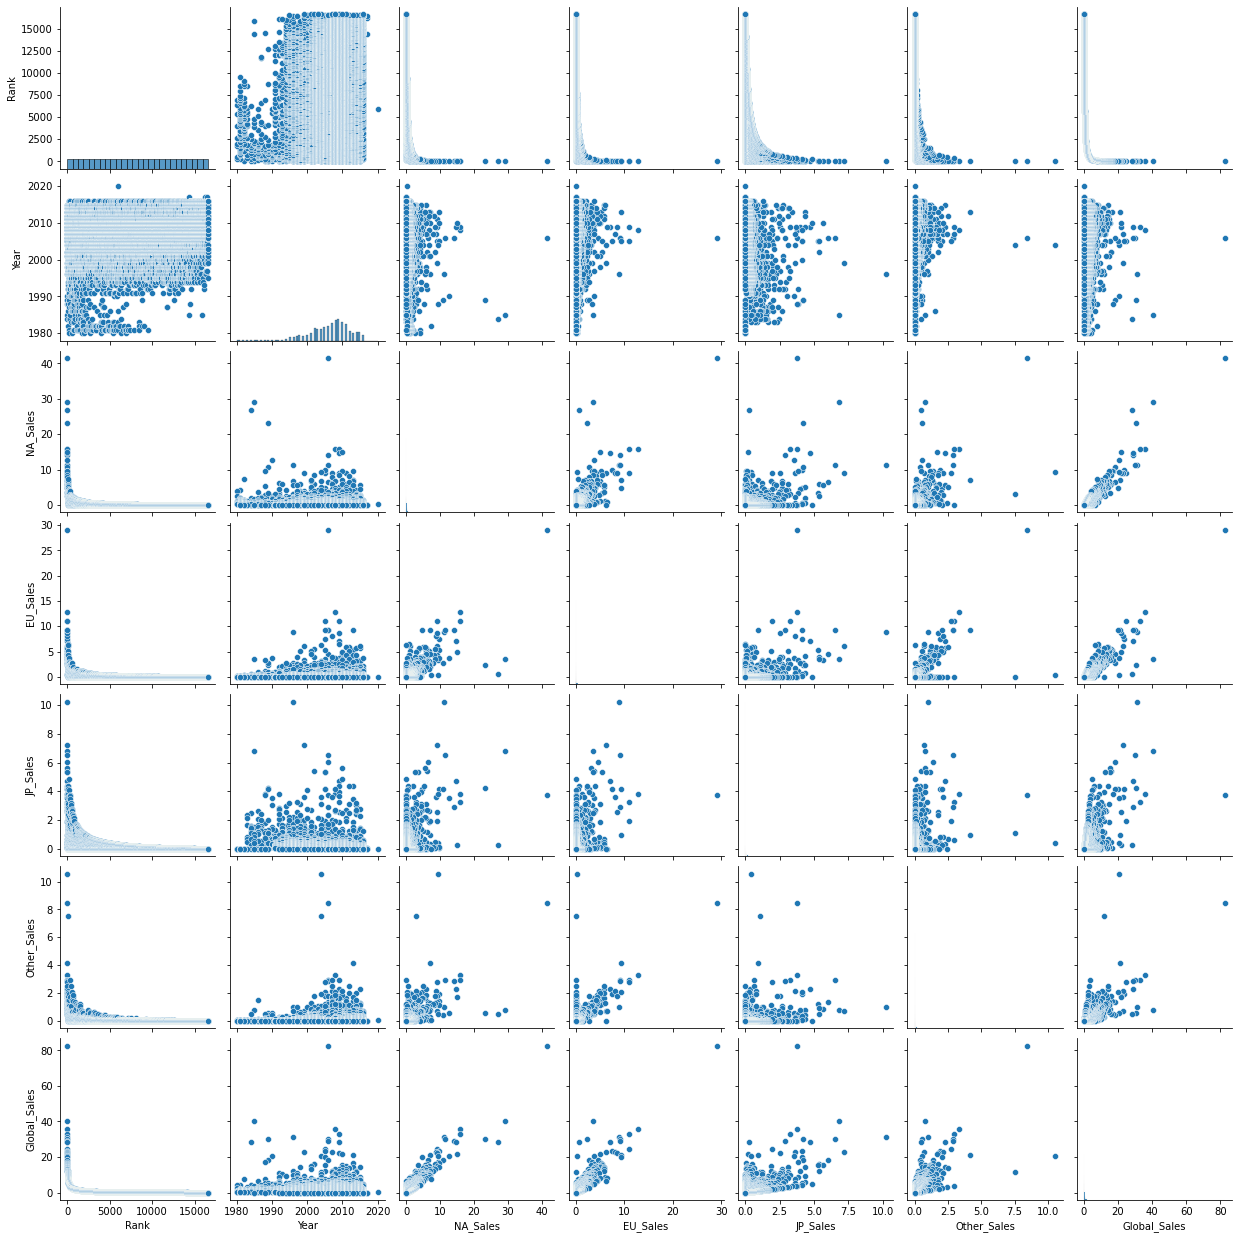

In [40]:
sns.pairplot(df.to_pandas())

sns.pairplotよりも柔軟にデータを見たいときは下記のようなコードで見るのもよいかも。  
時間も大して変わらなそう。

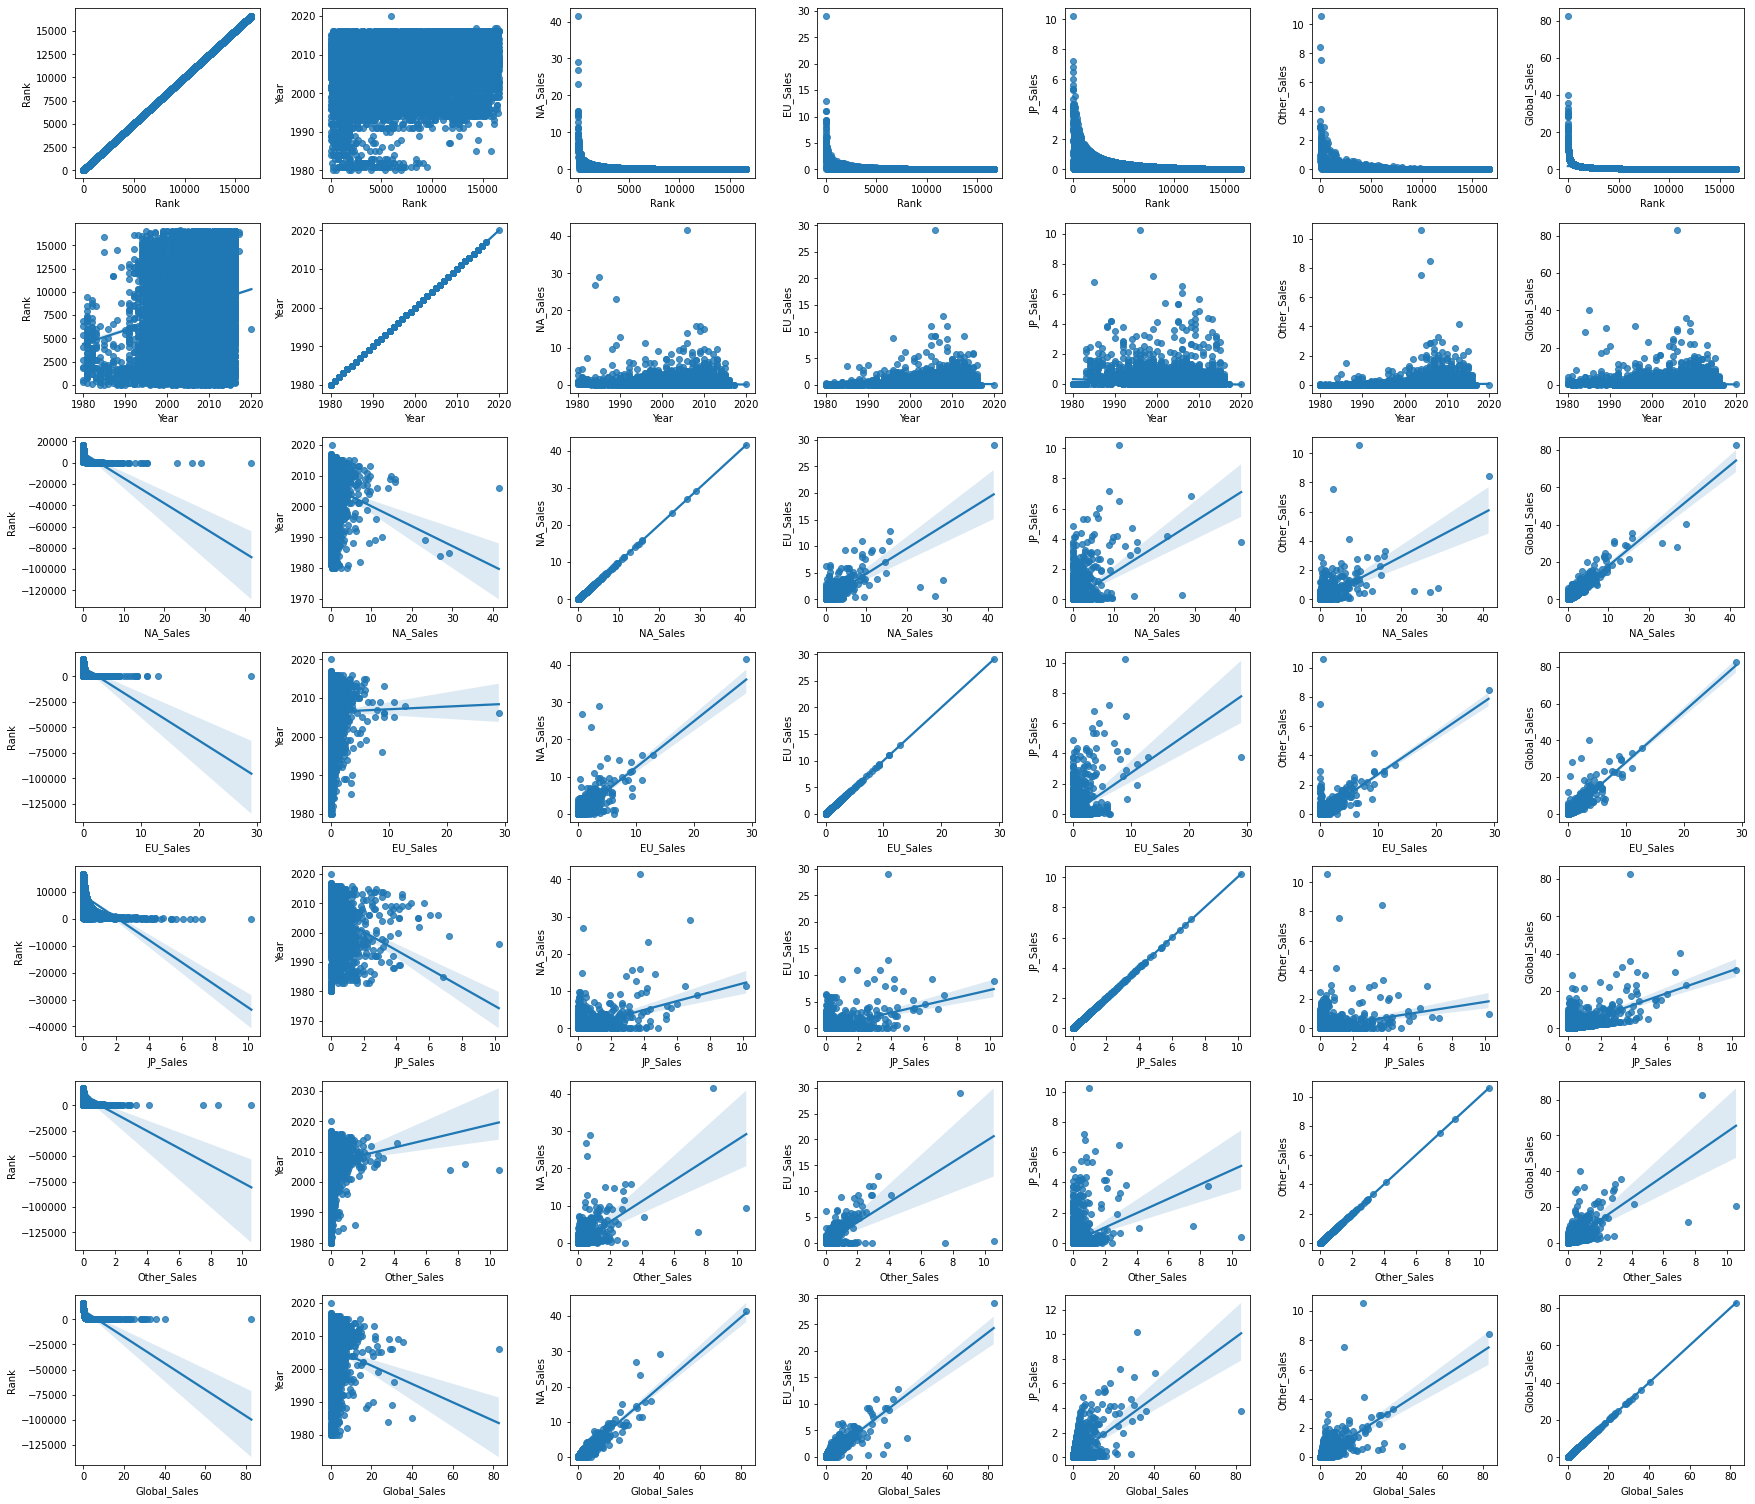

In [37]:
rows = 7
cols = 7
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5,rows*3))

# 行番号と列番号、量的変数の全組み合わせを取得する。
# これにより描画位置を指定し、各カラム同士の関係を可視化できる。
li_row_col = list(itertools.product(range(0, rows),range(0, cols)))
li_num_feats = list(itertools.product(num_feat, num_feat))
corr_coefs = {}

# 量的変数名のリストと描画位置のリストをzipでまとめる。
for feats, row_col in zip(li_num_feats, li_row_col):
    sns.regplot(x=df[feats[0]], y=df[feats[1]], ax=axes[row_col])
    # stats.pearsonrでピアソンの相関係数を求めるにはNaNを置き換えておく必要あり。
    # r, p = stats.pearsonr(x=df_train[feat], y=df_train[target])
    # targetとデータ型を合わせる必要あり。
    # corr_coef = df_train.select( pl.pearson_corr(target, pl.col(feat).cast(pl.Float64)) ).item()
    # corr_coefs[feat] = corr_coef
    # axes[row_col].set_title(f'corr_coef={corr_coef:.5f}', fontsize=11)
    axes[row_col].set_xlabel(feats[0])
    axes[row_col].set_ylabel(feats[1])
    
    
plt.tight_layout()

In [43]:
list(zip(df.columns, li_row_col))

[('Rank', (0, 0)),
 ('Name', (0, 1)),
 ('Platform', (0, 2)),
 ('Year', (0, 3)),
 ('Genre', (0, 4)),
 ('Publisher', (0, 5)),
 ('NA_Sales', (0, 6)),
 ('EU_Sales', (1, 0)),
 ('JP_Sales', (1, 1)),
 ('Other_Sales', (1, 2)),
 ('Global_Sales', (1, 3))]

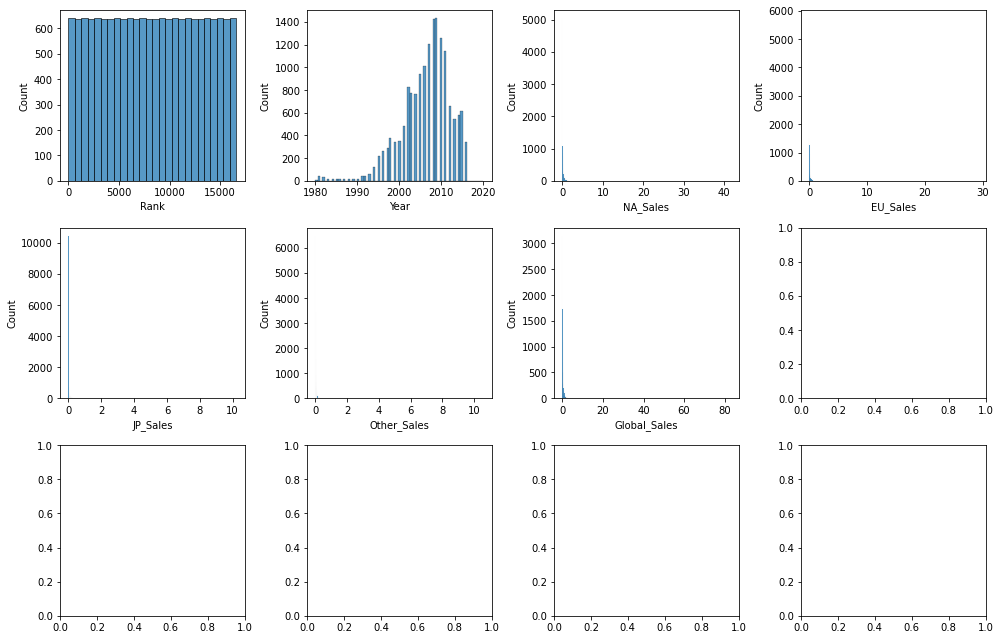

In [46]:
rows = 3
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5,rows*3))

# 行番号と列番号、量的変数の全組み合わせを取得する。
# これにより描画位置を指定し、各カラム同士の関係を可視化できる。
li_row_col = list(itertools.product(range(0, rows),range(0, cols)))

# 量的変数名のリストと描画位置のリストをzipでまとめる。
for feat, row_col in zip(num_feat, li_row_col):
    sns.histplot(x=df[feat], ax=axes[row_col])
    axes[row_col].set_xlabel(feat)


plt.tight_layout()

In [47]:
df.columns

['Rank',
 'Name',
 'Platform',
 'Year',
 'Genre',
 'Publisher',
 'NA_Sales',
 'EU_Sales',
 'JP_Sales',
 'Other_Sales',
 'Global_Sales']

In [60]:
a = df.filter(
  pl.col('NA_Sales').is_between(0, 2)
).get_column('NA_Sales')

(0.0, 500.0)

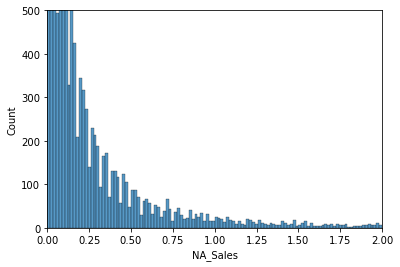

In [63]:
sns.histplot(x=a)
plt.xlim(0, 2.0)
plt.ylim(0, 500)